## Exercise 2: Bias-variance trade-off and resampling techniques 

In [1]:

import matplotlib.pyplot as plt
import numpy as np
import sklearn.linear_model as lm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample
from common import *
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

<Figure size 432x288 with 0 Axes>

## Bias-variance trade-off as function of model complexity : 

100%|██████████| 18/18 [00:00<00:00, 44.34it/s]


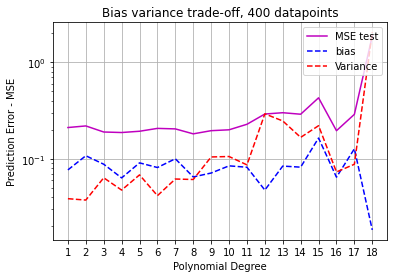

100%|██████████| 18/18 [00:02<00:00,  7.10it/s]


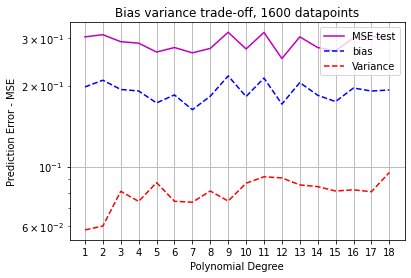

In [2]:
maxdegree = 18
for n in (20,40):
    SEED_VALUE = np.random.seed(4155)
    
    x = np.sort(np.random.uniform(0, 1, n))
    y = np.sort(np.random.uniform(0, 1, n))
    x,y = np.meshgrid(x,y)
    t = FrankeFunction(x,y) + noise_factor(n, factor = 0.3)

    MSE_test = np.zeros(maxdegree)
    MSE_train = np.zeros(maxdegree)
    bias = np.zeros(maxdegree)
    variance = np.zeros(maxdegree)
    t_flat = t.ravel().reshape(-1, 1)

    for degree in tqdm(range(1, maxdegree+1)):
        X = create_X(x, y, n=degree)
        X_train, X_test, t_train, t_test = prepare_data(
            X, t_flat, SEED_VALUE, test_size=0.2, shuffle=True, scale_X=True, scale_t=False)

    
        model = OLS()
        t_hat_train = model.fit(X_train, t_train)
        t_predicted = model.predict(X_test)

        MSE_test[degree-1] = MSE(t_test, t_predicted)
        bias[degree-1] = np.mean(t_test - np.mean(t_predicted))**2
        variance[degree-1] = np.var(t_predicted)
        
        
    plt.semilogy(np.arange(1,maxdegree+1), MSE_test,"m", label='MSE test')
    plt.semilogy(np.arange(1,maxdegree+1), bias,"b--", label='bias')
    plt.semilogy(np.arange(1,maxdegree+1), variance,"r--", label='Variance')
    #plt.plot(np.arange(1,maxdegree+1), variance+bias,"o--", label='CONTROL')


    plt.xlabel(f"Polynomial Degree")
    plt.ylabel("Prediction Error - MSE")

    plt.grid(True)
    plt.legend(loc=1)
    plt.title(f"Bias variance trade-off, {n**2} datapoints")
    plt.xticks(np.arange(1,maxdegree+1))
    #plt.savefig(f"{REPORT_FIGURES}{EX2}model_complexity_bias_var_function_n_{n}.pdf")
    plt.show()

## Bias-variance trade off with Bootstrap:


Looping trhough polynomials up to 15 with 96: 100%|██████████| 15/15 [00:38<00:00,  2.56s/it]


Elapsed time 38339.0124ms in function bootstrap


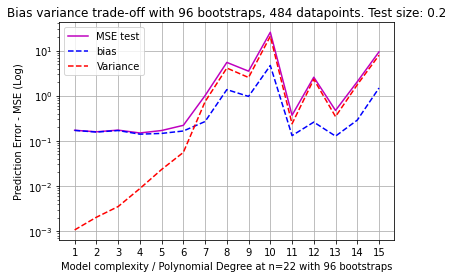

Looping trhough polynomials up to 15 with 320: 100%|██████████| 15/15 [00:40<00:00,  2.67s/it]


Elapsed time 40031.7287ms in function bootstrap


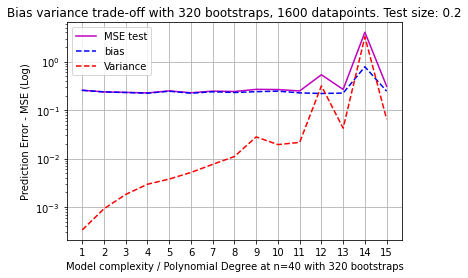

Looping trhough polynomials up to 15 with 96: 100%|██████████| 15/15 [00:07<00:00,  2.09it/s]


Elapsed time 7195.4145ms in function bootstrap


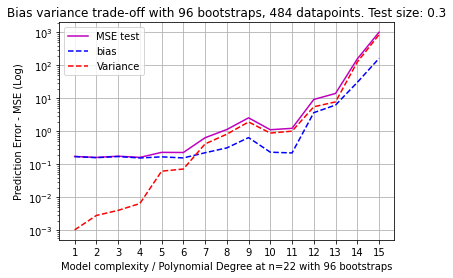

Looping trhough polynomials up to 15 with 320: 100%|██████████| 15/15 [00:28<00:00,  1.91s/it]


Elapsed time 28592.0939ms in function bootstrap


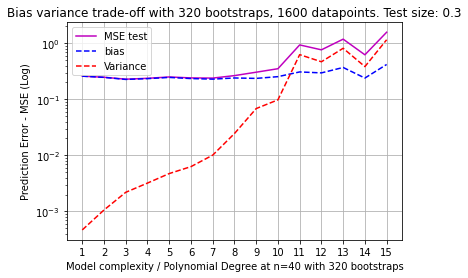

In [3]:
for test_size in (0.2,0.3):
    for n in (22,40):
        
        SEED_VALUE = np.random.seed(4155)
        n_bootstraps = int((n**2)/5)
        maxdegree = 15
        x = np.sort(np.random.uniform(0, 1, n))
        y = np.sort(np.random.uniform(0, 1, n))
        x,y = np.meshgrid(x,y)
        t = FrankeFunction(x,y) + noise_factor(n, factor=0.3)


        polydegree = np.arange(1, maxdegree+1)
        MSE_test, MSE_train, bias, variance = bootstrap(x, y, t, maxdegree, n_bootstraps, OLS(), SEED_VALUE, test_size = test_size)

        plt.semilogy(polydegree, MSE_test,"m", label='MSE test')
        plt.semilogy(polydegree, bias,"b--", label='bias')
        plt.semilogy(polydegree, variance,"r--", label='Variance')
        #plt.semilogy(polydegree, bias+variance,"o--", label='kontroll')
        # plt.ylim(0,2)
        #plt.plot(polydegree, bias+variance,"g--", label='bias+variance')

        plt.xlabel(f"Model complexity / Polynomial Degree at n={n} with {n_bootstraps} bootstraps")
        plt.ylabel("Prediction Error - MSE (Log)")
        plt.xticks(polydegree)
        plt.grid(True)
        plt.legend()
        plt.title(f"{n_bootstraps} bootstraps, {n**2} datapoints. Test size: {test_size}")
        #plt.savefig(f"{REPORT_FIGURES}{EX2}model_complexity_using_bootstrap_function_n_{n}_testsize_{test_size}.pdf")
        plt.show()